In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_rows', 20000)
# Set the path to the file you'd like to load
df = pd.read_csv('./drive/Shareddrives/FNB Dataquest/Dataset/data.csv', encoding='ISO-8859-1')
#display(df.duplicated(keep=False))
duplicates = df[df.duplicated(keep=False)]
#display(duplicates)
print(len(duplicates))

Mounted at /content/drive
10147


In [ ]:
#Hope

#Handle missing values
df.isnull().sum() #shows which columns have missing values
cleaned_dataset = df.dropna(subset=['CustomerID', 'Description']).copy()#Drop if essential

#Fill missing Description(if any still exist)
cleaned_dataset['Description'] = cleaned_dataset['Description'].fillna('unknown')

#Identify rows where Customer is missing
missing_cust_mask = cleaned_dataset['CustomerID'].isnull()

#Creates a mapping from InvoiceNoto new fake CustomerIDs (only for missing ones)
import hashlib

def generate_customer_id(invoice_no):
    """Hash the invoice number and convert to a fake customer ID (numeric)."""
    return int(hashlib.sha256(str(invoice_no).encode()).hexdigest(), 16) % 100000

#Apply only rows with missing CustomerID
cleaned_dataset.loc[missing_cust_mask, 'CustomerID'] = cleaned_dataset.loc[missing_cust_mask, 'InvoiceNo'].apply(generate_customer_id).astype(float)

#Convets CustomerID to integer and create knownCustomer column
cleaned_dataset['CustomerID'] = cleaned_dataset['CustomerID'].astype(int)
cleaned_dataset['knownCustomer'] = cleaned_dataset['CustomerID'].apply(lambda x: 0 if pd.isna(x) else 1)

#Standardize Description text (remove spaces and make lowercase)
cleaned_dataset['Description'] = cleaned_dataset['Description'].str.strip().str.lower()

#Remove duplicate rows
cleaned_dataset = cleaned_dataset.drop_duplicates()

#Remove Negative or Zero Prices
returns_df = cleaned_dataset[cleaned_dataset["Quantity"] < 0]
cleaned_dataset['feedback'] = cleaned_dataset['Quantity'].apply(lambda x: 0 if x < 0 else 1)

cleaned_dataset = cleaned_dataset[(cleaned_dataset['UnitPrice'] > 0) & (cleaned_dataset['Quantity'] > 0)]
print("Sample of returned Items:")
print(returns_df.head())

#Explore StockCode length and check which specific code(< 4 characters)occur and how frequently
cleaned_dataset['StockCode'].apply(lambda x: len(str(x))).value_counts()
cleaned_dataset[cleaned_dataset['StockCode'].astype(str).str.len() < 4]['StockCode'].value_counts()

#Remove invalid short StockCodes and known non-product codes
non_product_codes = ['POST', 'D', 'M', 'ADJUST', 'C2']

cleaned_dataset = cleaned_dataset[~(cleaned_dataset['StockCode'].str.len() < 4)].copy()
cleaned_dataset['StockCode'] = cleaned_dataset['StockCode'].astype(str)
cleaned_dataset = cleaned_dataset[~cleaned_dataset['StockCode'].isin(non_product_codes)]

#Check final StockCode length
print("Remaining StockCode lenghts: ")
print(cleaned_dataset['StockCode'].str.len().value_counts())
cleaned_dataset.head()

Sample of returned Items:
    InvoiceNo StockCode                      Description  Quantity  \
141   C536379         D                         discount        -1   
154   C536383    35004C  set of 3 coloured  flying ducks        -1   
235   C536391     22556    plasters in tin circus parade       -12   
236   C536391     21984  pack of 12 pink paisley tissues       -24   
237   C536391     21983  pack of 12 blue paisley tissues       -24   

         InvoiceDate  UnitPrice  CustomerID         Country  knownCustomer  
141   12/1/2010 9:41      27.50       14527  United Kingdom              1  
154   12/1/2010 9:49       4.65       15311  United Kingdom              1  
235  12/1/2010 10:24       1.65       17548  United Kingdom              1  
236  12/1/2010 10:24       0.29       17548  United Kingdom              1  
237  12/1/2010 10:24       0.29       17548  United Kingdom              1  
Remaining StockCode lenghts: 
StockCode
5     358277
6      32582
7        291
12        12

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,knownCustomer,feedback
0,536365,85123A,white hanging heart t-light holder,6,12/1/2010 8:26,2.55,17850,United Kingdom,1,1
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850,United Kingdom,1,1
2,536365,84406B,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850,United Kingdom,1,1
3,536365,84029G,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850,United Kingdom,1,1
4,536365,84029E,red woolly hottie white heart.,6,12/1/2010 8:26,3.39,17850,United Kingdom,1,1


Data Summary:
             Quantity      UnitPrice     CustomerID  knownCustomer  feedback
count  391165.000000  391165.000000  391165.000000       391165.0  391165.0
mean       13.144834       2.874684   15295.160538            1.0       1.0
std       180.804380       4.285148    1710.324268            0.0       0.0
min         1.000000       0.001000   12346.000000            1.0       1.0
25%         2.000000       1.250000   13969.000000            1.0       1.0
50%         6.000000       1.950000   15159.000000            1.0       1.0
75%        12.000000       3.750000   16794.000000            1.0       1.0
max     80995.000000     649.500000   18287.000000            1.0       1.0

Negative Quantity Count: 0

Filtered datasets saved: 0 negative quantity rows, 391165 non-negative quantity rows
Quantity: Shapiro-Wilk p-value = 0.00000 (Not Normal)
UnitPrice: Shapiro-Wilk p-value = 0.00000 (Not Normal)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 391165.
  res = hypotest_fun_out(*samples, **kwds)


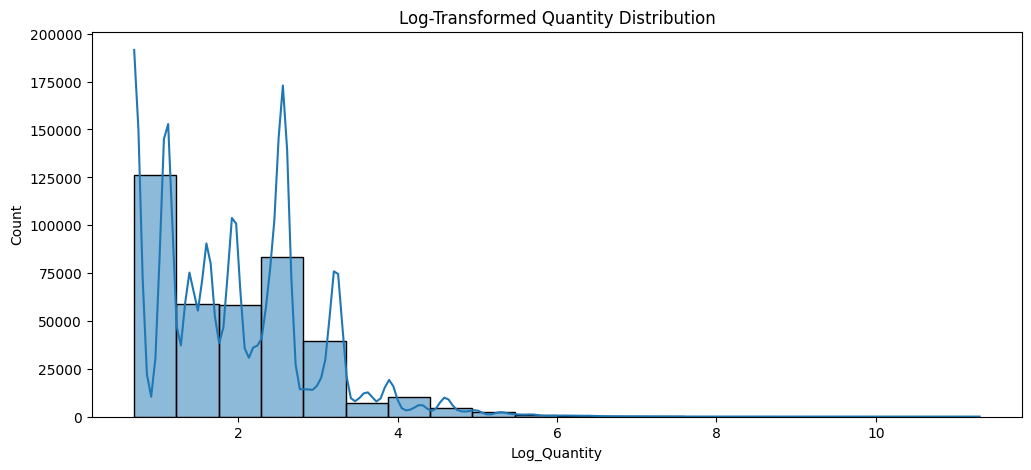

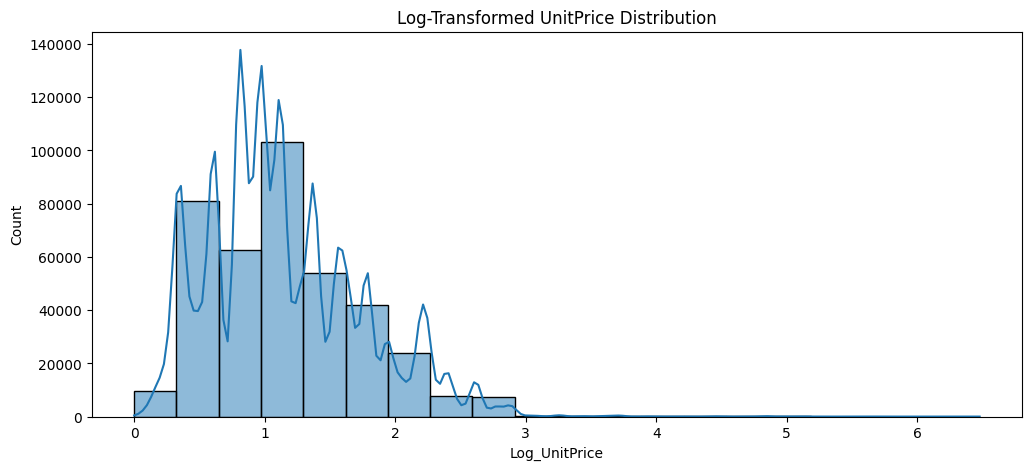

In [ ]:
#Elethu
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns


# Summary statistics on cleaned data
summary = cleaned_dataset.describe()
negative_quantity_count = (cleaned_dataset["Quantity"] < 0).sum()

print("Data Summary:\n", summary)
print(f"\nNegative Quantity Count: {negative_quantity_count}")

# Separate data into negative and non-negative quantity sets
negative_qty_df = cleaned_dataset[cleaned_dataset["Quantity"] < 0].copy()
non_negative_qty_df = cleaned_dataset[cleaned_dataset["Quantity"] >= 0].copy()

# Save filtered datasets with alternative filenames
negative_qty_df.to_csv("negative_quantity_dataset.csv", index=False)
non_negative_qty_df.to_csv("non_negative_quantity_dataset.csv", index=False)
print(f"\nFiltered datasets saved: {negative_qty_df.shape[0]} negative quantity rows, {non_negative_qty_df.shape[0]} non-negative quantity rows")

# Shapiro-Wilk normality test on Quantity and UnitPrice for non-negative quantity data
for col in ["Quantity", "UnitPrice"]:
    stat, p_value = ss.shapiro(non_negative_qty_df[col].dropna())
    normality = "(Normal)" if p_value > 0.05 else "(Not Normal)"
    print(f"{col}: Shapiro-Wilk p-value = {p_value:.5f} {normality}")

# Log-transform Quantity and UnitPrice to reduce skewness
non_negative_qty_df["Log_Quantity"] = np.log1p(non_negative_qty_df["Quantity"])
non_negative_qty_df["Log_UnitPrice"] = np.log1p(non_negative_qty_df["UnitPrice"])

# Plot log-transformed Quantity distribution
plt.figure(figsize=(12, 5))
sns.histplot(non_negative_qty_df["Log_Quantity"], bins=20, kde=True)
plt.title("Log-Transformed Quantity Distribution")
plt.show()

# Plot log-transformed UnitPrice distribution
plt.figure(figsize=(12, 5))
sns.histplot(non_negative_qty_df["Log_UnitPrice"], bins=20, kde=True)
plt.title("Log-Transformed UnitPrice Distribution")
plt.show()

In [ ]:
# Author: Bennedict Mkhonto

import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import StandardScaler


# Convert InvoiceDate to datetime
cleaned_dataset['InvoiceDate'] = pd.to_datetime(cleaned_dataset['InvoiceDate'])

# Calculate total price
cleaned_dataset['TotalPrice'] = cleaned_dataset['Quantity'] * cleaned_dataset['UnitPrice']

# ===========================
  # 2. Price Tier (Budget, Medium, Premium)
  # ===========================
price_bins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
cleaned_dataset['PriceTier'] = price_bins.fit_transform(cleaned_dataset[['UnitPrice']])
cleaned_dataset['PriceTier'] = cleaned_dataset['PriceTier'].map({0: 'Budget', 1: 'Medium', 2: 'Premium'})

def create_item_features(dataset):
  # ===========================
  # 1. Popularity Score
  # ===========================
  product_popularity = dataset.groupby('StockCode')['Quantity'].sum()
  product_popularity_norm = (product_popularity - product_popularity.min()) / (product_popularity.max() - product_popularity.min())
  dataset['PopularityScore'] = dataset['StockCode'].map(product_popularity_norm)

  # ===========================
  # 3. Purchase Frequency (unique invoices per product)
  # ===========================
  purchase_freq = dataset.groupby('StockCode')['InvoiceNo'].nunique()
  dataset['PurchaseFrequency'] = dataset['StockCode'].map(purchase_freq)

  # ===========================
  # 4. Co-Purchase Patterns
  # ===========================
  # Group items per invoice and drop invoices with fewer than 2 products
  baskets = dataset.groupby('InvoiceNo')['StockCode'].unique().reset_index()
  baskets = baskets[baskets['StockCode'].apply(lambda x: len(x) >= 2)]

  # ===========================
  # 5. Seasonality
  # ===========================
  dataset['Month'] = dataset['InvoiceDate'].dt.month
  dataset['Season'] = dataset['Month'].map({
      12: 'Winter', 1: 'Winter', 2: 'Winter',
      3: 'Spring', 4: 'Spring', 5: 'Spring',
      6: 'Summer', 7: 'Summer', 8: 'Summer',
      9: 'Fall', 10: 'Fall', 11: 'Fall'
  })

  # ===========================
  # 6. Weekday Purchases
  # ===========================
  dataset['Weekday'] = dataset['InvoiceDate'].dt.dayofweek  # Monday = 0, Sunday = 6
  dataset['IsWeekend'] = dataset['Weekday'].isin([5, 6]).astype(int)

  # ===========================
  # 7. Return Rates
  # ===========================
  dataset['IsReturn'] = dataset['InvoiceNo'].astype(str).str.startswith('C').astype(int)
  returns = dataset.groupby('StockCode')['IsReturn'].sum()
  sales = dataset.groupby('StockCode')['InvoiceNo'].count()
  return_rate = (returns / sales).fillna(0).clip(0, 1)
  dataset['ReturnRate'] = dataset['StockCode'].map(return_rate)

  # ===========================
  # Final Output Preview
  # ===========================
  cols_to_show = ['StockCode', 'PopularityScore', 'PriceTier', 'PurchaseFrequency', 'Season', 'Weekday', 'ReturnRate']
  return dataset[cols_to_show].drop_duplicates().copy()

stockcode_vocab = cleaned_dataset['StockCode'].unique()
stockcode_to_idx = {v: i for i, v in enumerate(stockcode_vocab)} #Integer encoding

customer_vocab = cleaned_dataset['CustomerID'].unique()
customer_to_idx = {v: i for i, v in enumerate(customer_vocab)} #Integer encoding

#Siyabonga
def encode_item_features(item_features):
  item_featurers = item_features.copy()
  #PRE_PROCESSING OF ITEM FEATURE TO PREPARE FOR MODELLING
  item_features['StockCode_idx'] = item_features['StockCode'].map(stockcode_to_idx)
    #One-Hot encode The rest of the categorical data
  cols_to_encode = ['PriceTier', 'Season']
  # Create one-hot encoded columns (without removing originals)
  encoded_cols = pd.get_dummies(item_features[cols_to_encode], dtype=float)
  item_features = pd.concat([item_features, encoded_cols], axis=1)
  scaler = StandardScaler()
  numeric_cols = ['PopularityScore', 'PurchaseFrequency', 'ReturnRate']
  item_features[numeric_cols] = scaler.fit_transform(item_features[numeric_cols])
  item_features = item_features.drop(columns=['StockCode', 'PriceTier', 'Season'])
  return pd.concat([item_features[['StockCode_idx'] + numeric_cols], encoded_cols], axis=1)


#Split dataset
cleaned_dataset = cleaned_dataset.sort_values(by="InvoiceDate")
cleaned_train_set, cleaned_test_set = np.split(cleaned_dataset, [int(0.67 * len(df))])



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
#Siyabonga

def customer_feature_extraction(dataset):
  # Purchase Frequency: number of unique purchases (InvoiceNo) per customer
  purchase_frequency = dataset.groupby('CustomerID')['InvoiceNo'].nunique().rename('PurchaseFrequency')

  # Monetary Value: sum of TotalPrice per customer
  monetary_value = dataset.groupby('CustomerID')['TotalPrice'].sum().rename('MonetaryValue')

  # Average Number of Items per Transaction
  avg_items_per_tx = dataset.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].sum().groupby('CustomerID').mean().rename('AvgItemsPerTransaction')

  # Recency: days since last purchase for each customer
  latest_date = dataset['InvoiceDate'].max()
  recency = dataset.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (latest_date - x).days).rename('RecencyDays')
  dataset.head()
  # Price Tier Preference: most common price tier per customer
  price_tier_pref = dataset.groupby(['CustomerID', 'PriceTier']).size().unstack(fill_value=0)
  price_tier_pref['PreferredTier'] = price_tier_pref.idxmax(axis=1)
  countries = dataset.groupby('CustomerID')['Country'].first().rename('Country')
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  #ELETHU !!
  # List of items/products bought per customer
  items_bought = dataset.groupby('CustomerID')['StockCode'].agg(list).rename('Bought')
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  customer_features = pd.concat([
    purchase_frequency,
    monetary_value,
    avg_items_per_tx,
    recency,
    price_tier_pref['PreferredTier'],
    countries,
    items_bought
  ], axis=1)
  customer_features = customer_features.reset_index()
  return customer_features

In [ ]:
#Siyabonga


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
import torch
import torch.nn as nn

# Map bought items to indices for use in dataset
def encode_bought_list(items):
    return [stockcode_to_idx[item] for item in items if item in stockcode_to_idx]
def encode_customer_ID(customerID):
    return customer_to_idx.get(customerID)

def encode_customer_features(customer_features):
    numerical_cols = ['PurchaseFrequency', 'MonetaryValue', 'AvgItemsPerTransaction', 'RecencyDays']
    # Scale numerical features
    scaler = StandardScaler()
    customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

    # Encode PreferredTier
    le_tier = LabelEncoder()
    customer_features['PreferredTier_encoded'] = le_tier.fit_transform(customer_features['PreferredTier'])

    # Encode Country with fallback for unseen

    le_country = LabelEncoder()
    customer_features['Country_encoded'] = le_country.fit_transform(customer_features['Country'])

    mlb = MultiLabelBinarizer()
    mlb.fit(customer_features['Bought'])
    num_items = len(mlb.classes_)
    # Encode bought items per user as list of item indices
    customer_features['Bought_encoded'] = customer_features['Bought'].apply(encode_bought_list)
    return customer_features.drop(columns=['Country', 'Bought', 'PreferredTier', 'CustomerID'])
x = customer_feature_extraction(cleaned_train_set)
x.head()
y = encode_customer_features(x)
y.head()

,PurchaseFrequency,MonetaryValue,AvgItemsPerTransaction,RecencyDays,PreferredTier_encoded,Country_encoded,Bought_encoded
0,-0.422931,9.171321,62.853852,2.257724,0,35,[2546]
1,0.271875,0.266952,0.110787,-0.668963,2,16,"[63, 198, 792, 1809, 1839, 160, 14, 62, 39, 71..."
2,-0.006047,-0.055603,0.285268,-0.301852,0,12,"[70, 388, 388, 1464, 1127, 1751, 694, 407, 282..."
3,-0.422931,-0.053129,0.325206,-0.872913,2,18,"[3492, 3605, 3214, 892, 3460, 3471, 507, 3150,..."
4,-0.422931,-0.194816,-0.043584,2.094564,1,24,"[293, 1301, 1418, 873, 1839, 318, 111, 328, 42..."




import numpy as np
df = df.sort_values(by="InvoiceDate")
train_set, test_set = np.split(df, [int(0.67 * len(df))])
print(f"Training set size: {train_set.shape}")
print(f"Test set size: {test_set.shape}")



In [ ]:
#siyabonga
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random


class UserDataset(Dataset):
    def __init__(self, user_vectors):
        # user_vectors: pandas Series or DataFrame with encoded user feature vectors
        user_feature_wo_col = user_vectors.drop(columns=['Bought_encoded'])
        self.user_vectors = torch.tensor(np.vstack(user_feature_wo_col.values), dtype=torch.float32)

    def __len__(self):
        return len(self.user_vectors)

    def __getitem__(self, idx):
        return self.user_vectors[idx]

class ItemDataset(Dataset):
    def __init__(self, item_df):
        # item_df must include 'StockCode_idx' and other feature columns
        self.stockcode_idx = torch.tensor(item_df['StockCode_idx'].values, dtype=torch.long)
        self.other_features = torch.tensor(item_df.drop(columns=['StockCode_idx']).values, dtype=torch.float32)

    def __len__(self):
        return len(self.stockcode_idx)

    def __getitem__(self, idx):
        return self.stockcode_idx[idx], self.other_features[idx]

class UserItemPairsDataset(Dataset):
    def __init__(self, user_df, item_df,user_bought_dict, num_negatives=5):

        user_feature_cols_for_tower = user_df.drop(columns=['Bought_encoded']).columns
        self.user_vectors = torch.tensor(user_df[user_feature_cols_for_tower].values, dtype=torch.float32)

        self.item_stockcodes = torch.tensor(item_df['StockCode_idx'].values, dtype=torch.long)
        self.item_features = torch.tensor(item_df.drop(columns=['StockCode_idx']).values, dtype=torch.float32)

        self.user_bought_dict = {
          idx: bought_list for idx, bought_list in user_df['Bought_encoded'].items()
        }
        self.num_negatives = num_negatives

        self.num_items = len(item_df)
        self.users = list(user_df.index)

    def __len__(self):
        return len(self.users) * self.num_negatives  # approximate

    def __getitem__(self, idx):
        # Randomly pick a user from self.users
        user_idx = self.users[idx % len(self.users)]

        user_vector = self.user_vectors[user_idx]

        # Positive items bought by user
        pos_items = self.user_bought_dict[user_idx]

        # Pick one positive item randomly
        pos_item_idx = np.random.choice(pos_items)
        pos_stockcode = self.item_stockcodes[pos_item_idx]
        pos_features = self.item_features[pos_item_idx]

        # Sample a negative item (not bought)
        while True:
            neg_item_idx = np.random.randint(0, self.num_items)
            if neg_item_idx not in pos_items:
                break

        neg_stockcode = self.item_stockcodes[neg_item_idx]
        neg_features = self.item_features[neg_item_idx]

        return {
            'user_vector': user_vector,
            'pos_stockcode': pos_stockcode,
            'pos_features': pos_features,
            'neg_stockcode': neg_stockcode,
            'neg_features': neg_features
        }


class UserTower(nn.Module):
    def __init__(self, input_dim):
        super(UserTower, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, user_features):
        return self.layers(user_features)

class ItemTower(nn.Module):
    def __init__(self, num_items, embedding_dim, input_feature_dim):
        super(ItemTower, self).__init__()
        self.embedding = nn.Embedding(num_items, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim+input_feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, stockcode_idx, features):
        embed = self.embedding(stockcode_idx)
        x = torch.cat([embed, features], dim=1)
        return self.fc(x)


def cosine_similarity(a, b):
    # a,b shape: (batch_size, embed_dim)
    a_norm = a / a.norm(dim=1, keepdim=True)
    b_norm = b / b.norm(dim=1, keepdim=True)
    return (a_norm * b_norm).sum(dim=1)

def contrastive_loss(user_embed, pos_item_embed, neg_item_embed, margin=0.2):
    # Maximize similarity with positive, minimize with negative by margin
    pos_sim = cosine_similarity(user_embed, pos_item_embed)
    neg_sim = cosine_similarity(user_embed, neg_item_embed)
    loss = torch.relu(margin - pos_sim + neg_sim).mean()
    return loss


def train_two_tower(user_tower, item_tower, dataloader, optimizer, epochs=10, device='cpu'):
    user_tower.to(device)
    item_tower.to(device)
    user_tower.train()
    item_tower.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()

            user_vec = batch['user_vector'].to(device)
            pos_stockcode = batch['pos_stockcode'].to(device)
            pos_features = batch['pos_features'].to(device)
            neg_stockcode = batch['neg_stockcode'].to(device)
            neg_features = batch['neg_features'].to(device)

            user_emb = user_tower(user_vec)
            pos_emb = item_tower(pos_stockcode, pos_features)
            neg_emb = item_tower(neg_stockcode, neg_features)

            loss = contrastive_loss(user_emb, pos_emb, neg_emb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

#Produce features for the training data
train_customer_features = customer_feature_extraction(cleaned_train_set)
tr_Encoded_customer_features = encode_customer_features(train_customer_features)

train_item_features = create_item_features(cleaned_train_set)
trEncoded_item_features = encode_item_features(train_item_features)
print(trEncoded_item_features.shape)

#Generate a User bought dictionary for positive and negative sampling
user_to_stockcodes = cleaned_dataset.groupby('CustomerID')['StockCode'].apply(list)
user_bought_dict = {}
for user_idx, stockcodes in enumerate(user_to_stockcodes):
    stockcode_idxs = [stockcode_to_idx[code] for code in stockcodes if code in stockcode_to_idx]
    if stockcode_idxs:
        user_bought_dict[user_idx] = stockcode_idxs

#Instantiate the datasets, towers and start training
user_dataset = UserDataset(tr_Encoded_customer_features)
item_dataset = ItemDataset(trEncoded_item_features)
#print(type(tr_Encoded_customer_features))
tr_Encoded_customer_features.head()
print(tr_Encoded_customer_features.shape)
user_item_dataset = UserItemPairsDataset(tr_Encoded_customer_features, trEncoded_item_features,user_bought_dict, num_negatives=5)
train_loader = DataLoader(user_item_dataset, batch_size=64, shuffle=True)
user_tower_input_dimensions = tr_Encoded_customer_features.drop(columns=['Bought_encoded']).shape[1]
print(user_tower_input_dimensions)
user_tower = UserTower(input_dim=user_tower_input_dimensions)
item_tower = ItemTower(num_items=trEncoded_item_features['StockCode_idx'].nunique(), embedding_dim=16, input_feature_dim=trEncoded_item_features.shape[1]-1)

optimizer = optim.Adam(list(user_tower.parameters()) + list(item_tower.parameters()), lr=0.001)

train_two_tower(user_tower, item_tower, train_loader, optimizer, epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu')


#Define functions to save the model
def save_model(user_tower, item_tower, optimizer, epoch, customer_to_idx, stockcode_to_idx,
               user_input_dim, item_input_dim, filename='./drive/Shareddrives/FNB Dataquest/Models/two_tower_checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'user_tower_state_dict': user_tower.state_dict(),
        'item_tower_state_dict': item_tower.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'customer_to_idx': customer_to_idx,
        'stockcode_to_idx': stockcode_to_idx,
        'user_input_dim': user_input_dim,
        'item_input_dim': item_input_dim,
    }
    torch.save(checkpoint, filename)
    print(f"Model saved to '{filename}'")


save_model(user_tower, item_tower, optimizer, epoch=50,
           customer_to_idx=customer_to_idx,
           stockcode_to_idx=stockcode_to_idx,
           user_input_dim=user_tower_input_dimensions,
           item_input_dim=trEncoded_item_features.shape[1]-1)


#Testing and evaluation of the model
#initialise device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
user_tower.to(device)
item_tower.to(device)
#Initialise dataset
customer_test_features = customer_feature_extraction(cleaned_test_set)
enc_customer_test_features = encode_customer_features(customer_test_features)
item_test_features =  create_item_features(cleaned_test_set)
enc_item_test_features = encode_item_features(item_test_features)

customer_test_features.head()
print(customer_test_features.loc[customer_test_features['CustomerID'] == 12347, "Bought"])
#Produce feature vectors
customer_test_vectors = torch.tensor(enc_customer_test_features.drop(columns=['Bought_encoded']).values, dtype=torch.float32).to(device)
item_test_feature_vectors = torch.tensor(trEncoded_item_features.drop(columns=['StockCode_idx']).values, dtype=torch.float32).to(device)
item_test_idx_vectors = torch.tensor(trEncoded_item_features['StockCode_idx'].values, dtype=torch.long).to(device)

print(type(enc_customer_test_features['Bought_encoded'].iloc[0]))
#Generate embeddings
with torch.no_grad():
    user_embs = user_tower(customer_test_vectors)
    item_embs = item_tower(item_test_idx_vectors,item_test_feature_vectors)

scores = torch.matmul(user_embs, item_embs.T).squeeze()

top_k = 7

# Map back to item StockCodes
idx_to_stockcode = {i: v for v, i in stockcode_to_idx.items()}
#Test if indices map to real stock codes

top_scores, indices = torch.topk(scores[0], k=top_k)
indices_list = indices.tolist()
selected_test_rows = enc_item_test_features.iloc[indices_list]
stockcode_idxs = selected_test_rows['StockCode_idx'].tolist()
for i in stockcode_idxs:
  print(idx_to_stockcode[i])


def indice_to_data(indices, user_idx):
  top_indices_list = indices.tolist()
  selected_test_rows = enc_item_test_features.iloc[top_indices_list]
  stockcode_idxs = selected_test_rows['StockCode_idx'].tolist()
  recommended_stockcodes = [idx_to_stockcode[i] for i in stockcode_idxs]
  item_desc_map = cleaned_dataset.drop_duplicates('StockCode').set_index('StockCode')['Description'].to_dict()
  recommended_items = [(stockcode, item_desc_map[stockcode]) for stockcode in recommended_stockcodes]
  actual_customer_id = customer_test_features.iloc[user_idx]['CustomerID']
  return (actual_customer_id, recommended_items)
#Testing matrics

def precision_at_k(top_k):
  average_precision_scores = [0.0] * (top_k - 1)
  average_recall_scores = [0.0] * (top_k - 1)
  test_length = len(customer_test_vectors)
  for k in range(1, top_k):
    for i in range(test_length):
      top_scores, top_indices = torch.topk(scores[i], k=top_k)
      CustomerID, recommended_items = indice_to_data(top_indices, i)
      true_items = customer_test_features.loc[customer_test_features['CustomerID'] == CustomerID, "Bought"].values[0]
      hit = 0;
      total_relevant = len(true_items)
      for j in range(k-1):
        recommended = recommended_items[j]
        if recommended in true_items:
          hit += 1
      precision = hit / k
      recall = (hit / total_relevant if total_relevant > 0 else 0.0)
      average_precision_scores[k-1] += precision
      average_recall_scores[k-1] += recall
    average_precision_scores[k-1] /= test_length
    average_recall_scores[k-1] /= test_length
  return average_precision_scores, average_recall_scores
precision, recall = precision_at_k(top_k)
print(f"Precision at {top_k}: {precision}")
print(f"Recall at {top_k}: {recall}")

#After Testing and evaluation, the model Produces a recall and Precision of 0.0
#We can thus conclude that this model is useless


Streaming output truncated to the last 5000 lines.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [ ]:
#Hope

#get top 10most popular items by qualitity sold
popular_items = cleaned_dataset.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)

#Keep only the first Description for each of these top 10 StockCodes
top_10_items = ( cleaned_dataset[cleaned_dataset['StockCode'].isin(popular_items.index)][['StockCode', 'Description']]
    .drop_duplicates(subset=['StockCode']) # keep one row per StockCode
    [['StockCode', 'Description']]
    .set_index('StockCode')
    .loc[popular_items.index] # make sure order matches popularity
)
#Add quantity values to the table
top_10_items['TotalQuantity'] = popular_items.values

print("Top 10 items to recommend to everyone: ")
print(top_10_items)

#Recommender function
def recommend_popular_items(n = 10):
    return top_10_items.head(n)

Top 10 items to recommend to everyone: 
                                  Description  TotalQuantity
StockCode                                                   
23843             paper craft , little birdie          80995
23166          medium ceramic top storage jar          77916
84077       world war 2 gliders asstd designs          54319
22197                    small popcorn holder          49160
85099B                jumbo bag red retrospot          46078
85123A     white hanging heart t-light holder          36763
84879           assorted colour bird ornament          35263
21212         pack of 72 retrospot cake cases          33670
23084                      rabbit night light          27153
22492                  mini paint set vintage          26076


In [ ]:
#Bennedict Mkhonto
#Collaboration filttering metod using the LightFm model
import pandas as pd
from lightfm import LightFM
from scipy.sparse import csr_matrix
import numpy as np

#Create user and item ID mappings (categorical to integer)
customer_ids = cleaned_dataset['CustomerID'].astype('category')
item_ids = df['StockCode'].astype('category')

cleaned_dataset['customer_idx'] = customer_ids.cat.codes
cleaned_dataset['item_idx'] = item_ids.cat.codes

num_users = customer_ids.cat.categories.size
num_items = item_ids.cat.categories.size

# Build sparse interaction matrix (customers x items)
interaction_matrix = csr_matrix(
    (cleaned_dataset['Quantity'], (cleaned_dataset['customer_idx'], cleaned_dataset['item_idx'])),
    shape=(num_users, num_items)
)

#Creates and train LightFM model for Collaboration filttering
model = LightFM(loss='warp')  # 'warp' loss works well for implicit data

model.fit(interaction_matrix, epochs=10, num_threads=4)

item_desc_map=(
    cleaned_dataset.drop_duplicates(subset='StockCode')[['StockCode','Description']].set_index('StockCode')['Description']
)

# A function to get the recommendations for all users
def sample_recommendations(model, interaction_matrix, customer_ids, item_ids,item_desc_map, N=7):
    n_customer, n_items = interaction_matrix.shape

    for customer_idx in range(n_customer):
        scores = model.predict(customer_idx, np.arange(n_items))
        top_items = np.argsort(-scores)[:N]

        print(f"\nRecommendations for customer {customer_ids.cat.categories[customer_idx]}:")
        for item_idx in top_items:
          stock_code = item_ids.cat.categories[item_idx]
          description = item_desc_map.get(stock_code, "No Description Available")
          print(f" Product: {stock_code}  {description}")

#Run recommendations function
sample_recommendations(model, interaction_matrix, customer_ids, item_ids,item_desc_map, N=7)


Streaming output truncated to the last 5000 lines.
 Product: 22469  heart of wicker small
 Product: 22470  heart of wicker large
 Product: 47566  party bunting
 Product: 22138  baking set 9 piece retrospot
 Product: 84879  assorted colour bird ornament

Recommendations for customer 17523:
 Product: 22144  christmas craft little friends
 Product: 22749  feltcraft princess charlotte doll
 Product: 21034  rex cash+carry jumbo shopper
 Product: 22141  christmas craft tree top angel
 Product: 22750  feltcraft princess lola doll
 Product: 22149  feltcraft 6 flower friends
 Product: 22150  3 stripey mice feltcraft

Recommendations for customer 17524:
 Product: 23355  hot water bottle keep calm
 Product: 85123A  white hanging heart t-light holder
 Product: 23301  gardeners kneeling pad keep calm
 Product: 22469  heart of wicker small
 Product: 21034  rex cash+carry jumbo shopper
 Product: 22086  paper chain kit 50's christmas
 Product: 22470  heart of wicker large

Recommendations for customer

In [ ]:
#Bennedict, Siyabonga
!pip install lightfm
import pandas as pd
from lightfm import LightFM
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from lightfm.evaluation import precision_at_k

cleaned_dataset = cleaned_dataset.sort_values(by="InvoiceDate")
cutoff_index = int(len(cleaned_dataset) * 0.8)


# Create user and item ID mappings (categorical to integer)
customer_ids = cleaned_dataset['CustomerID'].astype('category')
item_ids = cleaned_dataset['StockCode'].astype('category')

cleaned_dataset['customer_idx'] = customer_ids.cat.codes
cleaned_dataset['item_idx'] = item_ids.cat.codes

train_df = cleaned_dataset.iloc[:cutoff_index]
test_df = cleaned_dataset.iloc[cutoff_index:]


# Get shapes
num_users = cleaned_dataset['customer_idx'].max() + 1
num_items = cleaned_dataset['item_idx'].max() + 1

# Create sparse interaction matrices
train_interactions = csr_matrix(
    (train_df['Quantity'], (train_df['customer_idx'], train_df['item_idx'])),
    shape=(num_users, num_items)
)

test_interactions = csr_matrix(
    (test_df['Quantity'], (test_df['customer_idx'], test_df['item_idx'])),
    shape=(num_users, num_items)
)

model = LightFM(loss='warp')
model.fit(train_interactions, epochs=10, num_threads=4)



print("Train Precision@5:", precision_at_k(model, train_interactions, k=5).mean())
print("Test Precision@5:", precision_at_k(model, test_interactions, k=5).mean())
#The Collaborative filtering model produce considerable results compared to the neural Network
#From here we can confirm that Collaborative Filtering is better

ERROR: Operation cancelled by user


KeyboardInterrupt: 